# Periodic lake fracture and drainage (Figure 5)

## Problem description

This notebook produces Figure 5 from Miele et al. (2025). A supraglacial lake fills at a specified rate, inducing viscoplastic deflections, until accumulated plastic curvature (damage) reaches some threshold value. At this point, the lake drains until the accumulated curvature falls below the failure limit, and then the lake begins to fill again. This produces a periodic fill-drain cycle.

## Initial geometrical setup

In [1]:
Lx, Ly = 8000, 8000 #length, width (m)
nx, ny = 200, 200 #grid resolution
T = 273.15 - 0 #ice temperature (K)
κ_c = 1e-5 #critical stress threshold for plastic deflection (m^-1 a^-1)
H_gl = 100 #grounding line thickness (m)
u_gl = 1000 #u_x velocity (m/yr)
Δt = 1/20*(1/365) #timestep in years
num_years = 30/365 #duration of the simulation in years
valve_thresh = 1e-6 #once damage (m^-1) reaches this threshold, the lake begins to drain
K = 1/valve_thresh #scalar quantity used to normalize the drainage threshold (m)

R = 2000 #radius of the surface depression allowing meltwater pooling
amp = 1/2 #amplitude of the depression
fill_rate = 1/10*365 #filling rate of the pond in meters per year
drain_rate = fill_rate*-100 #drainage rate of the pond (m/yr)

transport_solver_path = '/home/firedrake/H3F/notebooks/flow/' #where the "transport_solver" module can be imported from
figures_path = '/home/firedrake/H3F/figures/2D_lake_drainage/' #where figures will be saved

## Imports

In [2]:
%%capture

from firedrake import *
import icepack
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
norm = colors.TwoSlopeNorm(vcenter = 0)
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from operator import itemgetter
import os
import tqdm

!pip install import_ipynb #this block is to allow importing transport_solver, which is not yet a part of icepack
import import_ipynb
os.chdir(transport_solver_path) #location of the transport solver notebook
from transport_solver import TransportEquation, TransportSolver

## Material parameters

In [3]:
ρ_i = 917 #density of ice (kg/m^3)
ρ_w = 1024 #density of seawater (kg/m^3)
ϱ = ρ_i/ρ_w #density ratio
g = 9.81 #gravitational constant (N/kg)
year = icepack.constants.year #number of seconds in a year
A = icepack.rate_factor(Constant(T)) #flow parameter

## Meshing 

In [4]:
mesh = RectangleMesh(nx, ny, Lx, Ly, name = f'my_mesh_{nx}_{T}_{u_gl}') #rectangle mesh
num_timesteps = int(num_years/Δt) + 1 #number of timesteps
deg = 1

Q = FunctionSpace(mesh, 'CG', deg) #function space for scalars (e.g., η)
S = TensorFunctionSpace(mesh, 'CG', deg) #function space for tensors (e.g, κ)
QS = Q*S #mixed function space for (η, κ)

q = Function(QS)
η_dot, κ_dot = split(q) #trial functions for the deflection rate and curvature rate
n_dot, k_dot = TestFunctions(QS) #test functions for those quantities
Δη = Function(Q) #function for each step's deflection update...
κ = Function(S) #...net curvature...
η = Function(Q) #...net deflection...
κ_p = Function(S) #...net plastic curvature...
γ = Function(Q) #...unitless damage parameter...
w, d = Function(Q), Function(Q) #...and watel level and water depth 

V = VectorFunctionSpace(mesh, 'CG', deg) #function space for vectors (e.g., u)
u_trial = TrialFunction(V) #trial function for the velocity
v = TestFunction(V) #test function for velocity

x, y = SpatialCoordinate(mesh)
X = np.arange(0, Lx, 1) #for plotting longitudinal profiles
X = np.array([(k, Ly/2) for k in X])

## Initialize SSA solver

We need to modify icepack's ```gravity``` and ```terminus``` functions to allow for surface elevations which do not perfectly align with buoyant equilibrium (since eventually vertical deflections will invalidate this). 

In [5]:
ρ_I, ρ_W = ρ_i/1e6/year**2, ρ_w/1e6/year**2 #put these values into icepack's preferred units
G = g*year**2

H_0 = Function(Q).project(Constant(H_gl)) #initial thickness
H = H_0.copy(deepcopy = True)
s = Function(Q).project((1 - ϱ)*H) #initial surface elevation

u_x = u_gl
u_y = 0
u = Function(V).project(as_vector((u_x, u_y)))

################################
################################
### modify icepack functions ###
################################
################################

def gravity(**kwargs): #see RHS of Eq. 44 in MacAyeal et al. (2021)
    u, H, s = itemgetter('velocity', 'thickness', 'surface')(kwargs)
    return -0.5* ρ_I*G*inner(grad(H**2), u) + 0.5*ρ_W*G*inner(grad((s - H)**2), u)

def terminus(**kwargs): #see Eq. 45 from MacAyeal et al. (2021)
    u, H, s = itemgetter('velocity', 'thickness', 'surface')(kwargs)
    mesh = u.ufl_domain()
    ν = FacetNormal(mesh)
    return 0.5*ρ_I*G*H**2*inner(u, ν) - 0.5*ρ_W*G*(s - H)**2*inner(u, ν)

def effective_viscosity(**kwargs): #also define a function that returns the effective viscosity
    flow_n = 3
    u = itemgetter('velocity')(kwargs)
    ε = sym(grad(u))
    ε_min = Constant(kwargs.get('strain_rate_min', icepack.constants.strain_rate_min))
    ε_e = Function(Q).project(icepack.models.viscosity._effective_strain_rate(ε, ε_min))
    ν = 1/2*A**(-1/flow_n)*ε_e**(1/flow_n - 1) #effective viscosity in MPa*yrs
    return Function(Q).project(ν*1e6) #return ν in units of Pa*yrs

###############################
###############################
### SSA boundary conditions ###
###############################
###############################

term_ids = [2] #boundaries are labeled (1, 2, 3, 4) = (upstream, downstream, left, right)
inflow_ids = [1]
sidewall_ids = [3, 4] #+/- y boundaries are free-slip sidewalls in this simulation

opts = {
    'dirichlet_ids': inflow_ids, 
    'side_wall_ids': sidewall_ids,
    'ice_front_ids': term_ids,
    'prognostic_solver_parameters': { #some optimization stuff 
        'ksp_type': 'gmres',
        'pc_type': 'ilu',
    },
}

flow_model = icepack.models.IceShelf(gravity = gravity, terminus = terminus) #model is icepack's SSA, but with our own physics
flow_solver = icepack.solvers.FlowSolver(flow_model, **opts)

## Spin up to steady state

In [6]:
residence_time = int(Lx/u_gl) #estimated number of years for grounding line ice to reach the terminus
dt = 1/10 #set the timestep to one tenth of a year

for step in tqdm.trange(int(residence_time/dt)):
    
    u = flow_solver.diagnostic_solve(velocity = u, side_friction = Constant(0),
                                     thickness = H, surface = s, fluidity = Constant(A))
    H = flow_solver.prognostic_solve(dt, thickness = H, velocity = u,
                                     thickness_inflow = H_0, accumulation = Constant(0))
    s = Function(Q).project((1 - ϱ)*H) #initial surface elevation

100%|███████████████████████████████████████████████████████████████████████████████████| 80/80 [01:02<00:00,  1.28it/s]


## Add a cosine-shaped surface depression to the steady-state geometry

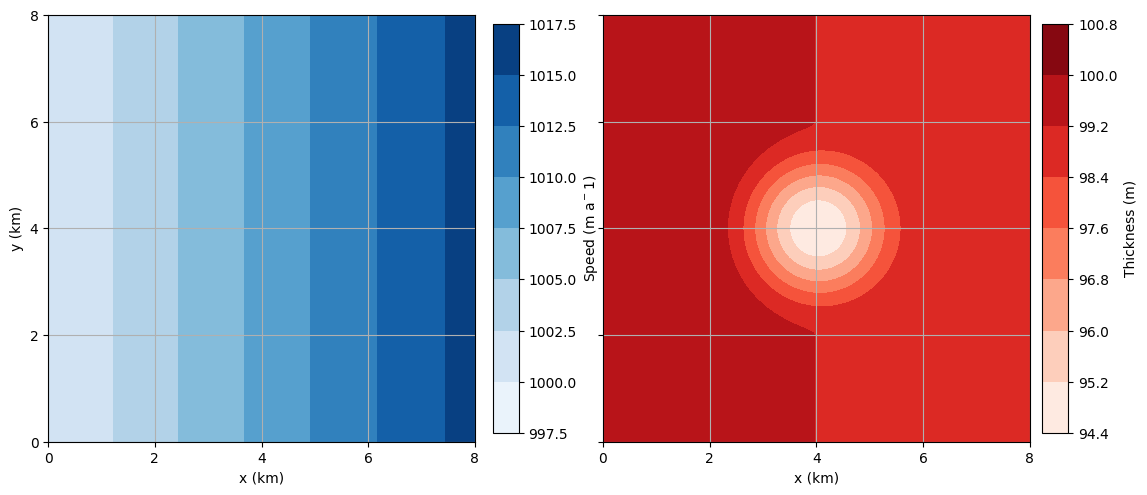

In [7]:
px, py = Lx/2, Ly/2 #coordinates of the center of the depression

D = conditional(
    sqrt((x - px)**2 + (y - py)**2) < R,  #check if a given coord is within the radius
    1/2 * amp * cos(pi * sqrt((x - px)**2 + (y - py)**2) / R) + 1/2 * amp,  #and if so, impose the cosine function here
    0  #else, zero outside the radius
)

s_0 = project(s - D, Q) #correct the initial surface topography for the depresion...
H_0 = project(s_0/(1 - ϱ), Q) #...but keep the shelf in equilibrium initially
b_0 = project(s_0 - H_0, Q)
s = s_0.copy(deepcopy = True)
H = H_0.copy(deepcopy = True)
b = b_0.copy(deepcopy = True)

depression_elevation = float(s.at((px, py), tolerance = 1e-10)) #the lowest point of the surface depression
w.project(Constant(depression_elevation)) #initialize water level 
d.project(Constant(0)) #initialize water depth

#################
#################
### and plot ####
#################
#################

# Create side-by-side subplots with shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5.6), sharey=True)  # Increased width to prevent overlap

# === PLOT 1: Initial Speed (Blues) ===
plot1 = tricontourf(Function(Q).project(sqrt(u[0]**2 + u[1]**2)), 
                     axes=ax1, cmap='Blues')  # Set colorbar range
ax1.set_aspect('equal')

ax1.set_xticks(range(0, Lx + 1, 2000))
ax1.set_xticklabels(range(0, int(Lx / 1000) + 1, 2))
ax1.set_yticks(range(0, Ly + 1, 2000))
ax1.set_yticklabels(range(0, int(Ly / 1000) + 1, 2))
# ax1.set_title('Initial Speed (m/yr)')
ax1.set_xlabel('x (km)')
ax1.set_ylabel('y (km)')
ax1.grid()

# === PLOT 2: Initial Thickness (Reds) ===
plot2 = tricontourf(Function(Q).project(H_0), axes=ax2, cmap='Reds')  # Set colorbar range
ax2.set_aspect('equal')

ax2.set_xticks(range(0, Lx + 1, 2000))
ax2.set_xticklabels(range(0, int(Lx / 1000) + 1, 2))
# ax2.set_title('Initial Thickness (m)')
ax2.set_xlabel('x (km)')
ax2.grid()

# === COLORBARS ===
# Adjusted to match **exact height** of the plots
pos1 = ax1.get_position()
pos2 = ax2.get_position()

cax1 = fig.add_axes([pos1.x1 + 0.00, pos1.y0 + 0.02, 0.02, pos1.height - 0.04])  # Now exactly as tall as plot 1
cax2 = fig.add_axes([pos2.x1 + 0.00, pos2.y0 + 0.02, 0.02, pos2.height - 0.04])  # Now exactly as tall as plot 2

cbar1 = fig.colorbar(plot1, cax=cax1)
cbar2 = fig.colorbar(plot2, cax=cax2)

cbar1.ax.set_ylabel(f'Speed (m a$^{-1}$)')
cbar2.ax.set_ylabel('Thickness (m)')

# Adjust layout with **precise horizontal spacing**
plt.subplots_adjust(wspace=0.3, right=0.88)  # Slightly increased `wspace` for balance

plt.show()

## Initialize transport solver and flexure boundary conditions

In this example, we assume that $\dot{\eta} = \dot{\boldsymbol{\kappa}} = 0$ on every boundary in order to focus on flexure induced by meltwater ponding near the center of the domain. 

In [8]:
########################
########################
### transport solver ###
########################
########################

transport_model = TransportEquation(field_name = 'field', conservative = False) #for advection of necessary variables
transport_solver = TransportSolver(transport_model, **opts) #e.g., η, 

###################################
###################################
### flexure boundary conditions ###
###################################
###################################

κ_bc = DirichletBC(QS.sub(1), 0*Identity(2), [term_ids, inflow_ids, sidewall_ids]) #κ_dot = 0 on each boundary
η_bc = DirichletBC(QS.sub(0), 0, [term_ids, inflow_ids, sidewall_ids]) #η_dot = 0 on each boundary

#######################
#######################
### set figure path ###
#######################
#######################

path = figures_path + f'H-{H_gl}_u-{u_gl}_T-{T}_nx-{nx}_kappa-{κ_c}_thresh-{valve_thresh}_fill_rate-{fill_rate}_drain_rate-{drain_rate}'

try:
    os.chdir(path)
except:
    os.mkdir(path)
    os.chdir(path)

In [9]:
os.getcwd()

'/home/firedrake/H3F/figures/2D_lake_drainage/H-100_u-1000_T-273.15_nx-200_kappa-1e-05_thresh-1e-06_fill_rate-36.5_drain_rate--3650.0'

## Solve the flow-flexure problem iteratively

...following the steps laid out in Appendix B. Additionally, the water level within the surface depression is updated each timestep. The water level at the center of the depression changes according not just to the fill rate, but also in response to any deflections, which adjust the entire shelf's vertical position. That is, every iteration, the water level ```w``` is changed by a value of ```fill_rate*Δt + η_dot*Δt``` while ```filling == True```, or by ```drain_rate*Δt + η_dot*Δt``` while ```draining == True```. The status of ```filling``` or ```draining```, in turn, depends on the accumulated plastic damage calculated at the end of each iteration. 

100%|██████████████████████████████████████████████████████████████████████████████▊| 599/600 [3:48:58<00:23, 23.03s/it]

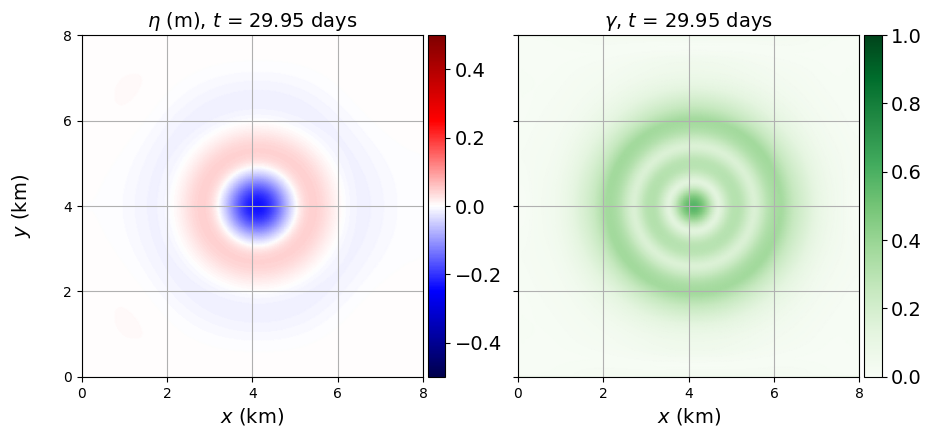

100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [3:49:21<00:00, 22.94s/it]


In [10]:
max_depth, max_γ = [], []
η_profile, κ_profile, d_profile = [], [], []
filling = True
draining = False

for step in tqdm.trange(num_timesteps):

    #########################
    #########################
    ### (1) flow solution ###
    #########################
    #########################
        
    u = flow_solver.diagnostic_solve(velocity = u, side_friction = Constant(0), 
                             thickness = H, surface = s)
    b = flow_solver.prognostic_solve(Δt, thickness = b, velocity = u,
                                     thickness_inflow = b_0, accumulation = Constant(0))
    s = flow_solver.prognostic_solve(Δt, thickness = s, velocity = u,
                                     thickness_inflow = s_0, accumulation = Constant(0)) 

    ##########################################
    ##########################################
    ### (2) update flow-related parameters ###
    ##########################################
    ##########################################

    s = Function(Q).project(s)
    H = Function(Q).project(s - b) #initial basal elevation
        
    ε = Function(S).project(sym(grad(u))) #strain rate tensor
    ν = effective_viscosity(velocity = u) #effective viscosity
    τ = Function(S).project(2*ν*ε) #deviatoric stress tensor
    P = -tr(τ) + 1/2*ρ_i*g*H #depth-averaged pressure
    σ = τ - P*Identity(2) #depth-averaged net stress tensor
    
    h_ab = Function(Q).project(s - (1 - ϱ)*H)

    ############################
    ############################
    ### (3) flexure solution ###
    ############################
    ############################

    q = Function(QS)
    η_dot, κ_dot = split(q)
    
    J_II = sqrt(1/2*(κ_dot[0, 0]**2 + κ_dot[1, 1]**2 + κ_dot[0, 1]**2 + κ_dot[1, 0]**2)) #J_II of κ_dot
    β = 1/2 #as described in Appendix B
    α = conditional(J_II > κ_c, (κ_c + β*(J_II - κ_c))/J_II, 1) #Appendix B

    C = Function(Q).project(1/6*ν*H**3)
    a = dot(div(C*κ_dot + C*tr(κ_dot)*Identity(2)), grad(n_dot))*dx - n_dot*ρ_w*g*η_dot*Δt*dx - dot(grad(η_dot*Δt), div(n_dot*H*σ))*dx   
    a += α*inner(ν*κ_dot, k_dot)*dx + dot(grad(η_dot), div(ν*k_dot))*dx
    L = n_dot*ρ_w*g*(h_ab)*dx + dot(grad(η), div(n_dot*H*σ))*dx #the weak form given in Appendix B 
    L += n_dot*1000*g*d*dx #with an additional term for meltwater loading, as in Equation 21

    solve(a - L == 0, q, bcs = [η_bc, κ_bc])


    ###################################
    ###################################
    ### (3.5) update the lake level ###
    ###################################
    ###################################

    u_p = u.at((px, py), tolerance = 1e-10) #velocity at the depression center
    px = px + u_p[0]*Δt #we'll need to keep track of the coordinates of the depression center...
    py = py + u_p[1]*Δt #...as ice moves forward with flow

    Δη.project(η_dot*Δt) #record the change in deflection...
    s.project(s + Δη) #...and the new surface elavation, both of which will inform the step change to the lake level
    depression_elevation = float(s.at((px, py), tolerance = 1e-10)) #record the elevation at the center of the depression
        
    if filling:
        Δw = fill_rate*Δt + Δη.at((px, py), tolerance = 1e-10) #water level moves with fill_rate plus any surface deflection
        w.project(w + Δw) #adjust the water level
        d.project(max_value(w - s, 0)) #water depth is the positive distance between the surface and the water level
    elif draining:
        Δw = drain_rate*Δt + Δη.at((px, py), tolerance = 1e-10)
        w.project(max_value(w + Δw, depression_elevation)) #water level can go no lower than the bottom of the depression
        d.project(max_value(w - s, 0))

    ########################################################
    ########################################################
    ### (4) update and advect flexure-related parameters ###
    ########################################################
    ########################################################
    
    η.project(η + Δη)
    b.project(b + Δη)
    Δκ = κ_dot*Δt
    κ = Function(S).project(κ + Δκ)
    κ_p = Function(S).project(κ_p + (α - 1)*Δκ)
    
    #also define each component of the curvature tensors explicitly for advection
    κ_xx, κ_xy, κ_yy = Function(Q).project(κ[0, 0]), Function(Q).project(1/2*(κ[0, 1] + κ[1, 0])), Function(Q).project(κ[1, 1])
    κp_xx, κp_xy, κp_yy = Function(Q).project(κ_p[0, 0]), Function(Q).project(1/2*(κ_p[0, 1] + κ_p[1, 0])), Function(Q).project(κ_p[1, 1])

    η = transport_solver.prognostic_solve(Δt, field = η, velocity = u, field_inflow = η, field_accumulation = Constant(0)) #advect
    η = Function(Q).project(η)

    κ_xx = transport_solver.prognostic_solve(Δt, field = κ_xx, velocity = u, field_inflow = κ_xx, field_accumulation = Constant(0))
    κ_xy = transport_solver.prognostic_solve(Δt, field = κ_xy, velocity = u, field_inflow = κ_xy, field_accumulation = Constant(0))
    κ_yy = transport_solver.prognostic_solve(Δt, field = κ_yy, velocity = u, field_inflow = κ_yy, field_accumulation = Constant(0))
    κp_xx = transport_solver.prognostic_solve(Δt, field = κp_xx, velocity = u, field_inflow = κp_xx, field_accumulation = Constant(0))
    κp_xy = transport_solver.prognostic_solve(Δt, field = κp_xy, velocity = u, field_inflow = κp_xy, field_accumulation = Constant(0))
    κp_yy = transport_solver.prognostic_solve(Δt, field = κp_yy, velocity = u, field_inflow = κp_yy, field_accumulation = Constant(0))
    
    η = Function(Q).project(η)
    κ.project(as_tensor([[κ_xx, κ_xy], [κ_xy, κ_yy]]))
    κ_p.project(as_tensor([[κp_xx, κp_xy], [κp_xy, κp_yy]]))
    γ = Function(Q).project(sqrt(1/2*(κ_p[0, 0]**2 + κ_p[1, 1]**2 + κ_p[0, 1]**2 + κ_p[1, 0]**2))) #damage as J_II(κ_p)

    #########################################
    #########################################
    ### (4.5) check the drainage criteria ###
    #########################################
    #########################################
    
    γ_forcing = Function(Q).project(conditional(sqrt((x - px)**2 + (y - py)**2) < R, γ, 0)) #only consider damage at the depression
    valve_forcing = max(γ_forcing.dat.data) #identify the max value of γ within R of the depression's center
    if valve_forcing > valve_thresh:
        filling = False
        draining = True
    else:
        filling = True
        draining = False

    ###############
    ###############
    ### figures ###
    ###############
    ###############

    γ.project(K*γ) #normalize damage for plotting
    max_depth.append(max(d.dat.data)) #record for plotting
    max_γ.append(valve_forcing) #record for plotting
    η_profile.append(η.at(X, tolerance = 1e-10))
    d_profile.append(d.at(X, tolerance = 1e-10))
    κ_profile.append(γ.at(X, tolerance = 1e-10))

    plt.figure() #plot a 2D cross-section of the self for easy visualization of water level
    plt.plot(Function(Q).project(s + d).at(X, tolerance = 1e-10), color = 'b', label = 'water level')
    plt.plot(s.at(X, tolerance = 1e-10), color = 'k', label = 'ice surface')
    plt.xticks(range(0, Lx + 1, 2000), range(0, int(Lx/1000) + 1, 2), fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.xlabel('longitudinal coordinate (km)', fontsize = 16)
    plt.ylabel('elevation (m)', fontsize = 16)
    plt.ylim(9, 11)
    plt.legend(fontsize = 16)
    plt.grid()
    plt.title(f'$t$ = {365*step*Δt:.2f} days', fontsize = 16)
    plt.tight_layout()
    plt.savefig(f'surface_{step}')
    plt.close()

    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True, gridspec_kw={'wspace': 0.2})
    plots = [(η, 'seismic', -0.5, 0.5, r'$\eta$ (m)'),
             (γ, 'Greens', 0, K * valve_thresh, r'$\gamma$')]
    for ax, (data, cmap, vmin, vmax, title) in zip(axes, plots):
        ax.set_aspect('equal')
        plot = tripcolor(data, axes=ax, cmap=cmap, vmin=vmin, vmax=vmax)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(plot, cax=cax)
        cbar.ax.tick_params(labelsize=14, direction='out')
        ax.set_xticks(range(0, Lx + 1, 2000))
        ax.set_xticklabels(range(0, int(Lx / 1000) + 1, 2), fontsize=10)
        ax.set_xlabel('$x$ (km)', fontsize=14)
        ax.set_title(f'{title}, $t$ = {365 * step * Δt:.2f} days', fontsize=14)
        ax.grid()
    axes[0].set_yticks([])  # Remove y-ticks from the left plot
    axes[1].set_yticks(range(0, Ly + 1, 2000))
    axes[1].set_yticklabels(range(0, int(Ly / 1000) + 1, 2), fontsize=10)
    axes[1].yaxis.tick_left()
    axes[1].yaxis.set_label_position("left")
    axes[0].set_ylim(0, Ly)
    axes[0].set_xlim(0, Lx)
    axes[1].set_xlim(0, Lx)
    fig.text(0.04, 0.5, '$y$ (km)', va='center', ha='center', fontsize=14, rotation=90)
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2)
    plt.savefig(f'η_γ_{step}.png')

    if num_timesteps - step > 1:
        plt.close()
    else:
        plt.show() #only show the last plot

## Save additional plots for manuscript

In [11]:
# Define global font size variables
fontsize = 12
fontsize_ticks = 10

# Create figure
fig = plt.figure(figsize=(10, 5.6))

density = 1

# Expand profiles efficiently
η_profile_expanded = np.repeat(np.array(η_profile), density, axis=0).T
κ_profile_expanded = np.repeat(np.array(κ_profile), density, axis=0).T
d_profile_expanded = np.repeat(np.array(d_profile), density, axis=0).T

### **Manually Adjusted Subplot Positions (Shift Up)**

top_subplot_height = 0.30  # Keep top at 0.95
small_subplot_height = 0.18  # Keep these unchanged

ax4 = fig.add_axes([0.1, 0.67, 0.65, top_subplot_height])  # Shifted up
ax1 = fig.add_axes([0.1, 0.46, 0.65, small_subplot_height])  # Shifted up
ax2 = fig.add_axes([0.1, 0.25, 0.65, small_subplot_height])  # Shifted up
ax3 = fig.add_axes([0.1, 0.04, 0.65, small_subplot_height])  # Shifted up

####### **TOP PLOT (LINE PLOT)** #######
ax4.plot(max_depth, color='blue', linewidth=1, label='depth')
ax4.set_ylabel('max $\gamma$', fontsize=fontsize, color='black')
ax4.set_ylim(-0.1, 1.1)
ax4.grid()

ax5 = ax4.twinx()
ax5.plot([entry * 1e6 for entry in max_γ], color='k', linewidth=1, linestyle='solid', label='curvature')
ax5.axhline(valve_thresh * 1e6, color='k', linestyle='dashed', label='threshold value')

ax5.set_ylabel('max depth', fontsize=fontsize, color='blue')
ax5.set_ylim(-0.1, 1.1)

# **Ensure y-ticks only appear at 0 and 1 for both y-axes (ax4 and ax5)**
ax4.set_yticks([0, 1])
ax4.set_yticklabels(["0", "1"], fontsize=fontsize_ticks)

ax5.set_yticks([0, 1])
ax5.set_yticklabels(["0", "1"], fontsize=fontsize_ticks, color='blue')

####### **IMAGE PLOTS** #######

for ax, data, cmap, cbar_pos, cbar_ticks in zip(
    [ax1, ax2, ax3],
    [η_profile_expanded, κ_profile_expanded, d_profile_expanded],
    ['seismic', 'Greens', 'Blues'],
    [0.46, 0.25, 0.04],  # Shifted colorbars accordingly
    [[-0.5, 0.5], [0, 1], [0, 1]]
):
    im = ax.imshow(data, cmap=cmap, vmin=cbar_ticks[0], vmax=cbar_ticks[1], aspect='auto')
    ax.set_ylabel('x (km)', fontsize=fontsize)
    ax.set_yticks([0, Lx / 2, Lx])
    ax.set_yticklabels(["0", "4", "8"], fontsize=fontsize_ticks)
    ax.grid()

    # Add colorbar
    cax = fig.add_axes([0.77, cbar_pos, 0.02, small_subplot_height])
    cbar = fig.colorbar(im, cax=cax, ticks=cbar_ticks)
    cbar.ax.set_yticklabels([f"{v:g}" for v in cbar_ticks], fontsize=fontsize_ticks)

# **Ensure only the bottom subplot has x-axis labels**
x_ticks = np.arange(0, η_profile_expanded.shape[1], 100 * density)
x_tick_labels = ["{:.0f}".format(label) for label in x_ticks / (density / Δt) * 365]

for ax in [ax1, ax2]:
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([])
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax3.set_xticks(x_ticks)
ax3.set_xticklabels(x_tick_labels, fontsize=fontsize_ticks)
ax3.set_xlabel('time (days)', fontsize=fontsize)
ax4.set_xticklabels([])

# Save and show figure
plt.savefig('figure_4_ABCD.png')
plt.close()

In [12]:
# Define global font size variables
fontsize = 12
fontsize_ticks = 10

# Create figure (ensure vertical span matches first figure)
fig = plt.figure(figsize=(5.6, 5.6))  # Ensure the height aligns with the first figure

### **Manually Set Subplot Positions to EXACTLY Match First Figure**
bottom_margin = 0.04  # Keep consistent with the first figure
top_limit = 0.97  # Keep consistent with the first figure
gap_between_panels = 0.05  # Ensure spacing consistency

# **Calculate Panel Heights (Exactly Matching the First Figure)**
panel_height = (top_limit - bottom_margin - gap_between_panels) / 2  # Match left-side figure
panel_width = panel_height  # Ensure square aspect ratio

# **Exact positioning to align with the first figure**
ax1_bottom = bottom_margin + panel_height + gap_between_panels  # Align top panel
ax2_bottom = bottom_margin  # Align bottom panel

# **Manually set positions to ensure alignment**
ax1 = fig.add_axes([0.1, ax1_bottom, panel_width, panel_height])  # Top subplot
ax2 = fig.add_axes([0.1, ax2_bottom, panel_width, panel_height])  # Bottom subplot

####### **TOP PLOT (PLASTIC DAMAGE - κ FIELD)** #######
im1 = tripcolor(γ, axes=ax1, cmap='Greens', vmin=0, vmax=K * valve_thresh)

ax1.set_ylabel('y (km)', fontsize=fontsize)
ax1.set_xticks(range(0, 9000, 2000))  
ax1.set_xticklabels([])  # Remove x-axis labels but retain ticks for grid alignment
ax1.set_yticks(range(0, 9000, 2000))
ax1.set_yticklabels(range(0, 9, 2), fontsize=fontsize_ticks)
ax1.set_xlim(0, 8000)  
ax1.set_ylim(0, 8000)  
ax1.grid()

# **Move Colorbar Closer & Ensure Alignment**
cax1 = fig.add_axes([0.77, ax1_bottom, 0.03, panel_height])  
cbar1 = fig.colorbar(im1, cax=cax1, ticks=[0, 1])
cbar1.ax.set_yticklabels(['0', '1'], fontsize=fontsize_ticks)  # Remove label

####### **BOTTOM PLOT (NET DEFLECTION - η FIELD)** #######
im2 = tripcolor(η, axes=ax2, cmap='seismic', vmin=-1/2, vmax=1/2)

ax2.set_xlabel('x (km)', fontsize=fontsize)
ax2.set_ylabel('y (km)', fontsize=fontsize)
ax2.set_xticks(range(0, 9000, 2000))
ax2.set_xticklabels(range(0, 9, 2), fontsize=fontsize_ticks)
ax2.set_yticks(range(0, 9000, 2000))
ax2.set_yticklabels(range(0, 9, 2), fontsize=fontsize_ticks)
ax2.set_xlim(0, 8000)  
ax2.set_ylim(0, 8000)  
ax2.grid()

# **Move Colorbar Closer & Ensure Alignment**
cax2 = fig.add_axes([0.77, ax2_bottom, 0.03, panel_height])  
cbar2 = fig.colorbar(im2, cax=cax2, ticks=[-1/2, 0, 1/2])
cbar2.ax.set_yticklabels([r"$-0.5$", "0", r"$0.5$"], fontsize=fontsize_ticks)  

# **Manually Adjust Subplot Positions to Ensure Perfect Alignment**
ax1.set_position([0.1, ax1_bottom, panel_width, panel_height])
ax2.set_position([0.1, ax2_bottom, panel_width, panel_height])
cax1.set_position([0.58, ax1_bottom, 0.03, panel_height])
cax2.set_position([0.58, ax2_bottom, 0.03, panel_height])

ax1.plot([0, 8e3], [4e3, 4e3], 'k--', linewidth=1, dashes=(5, 5))
ax2.plot([0, 8e3], [4e3, 4e3], 'k--', linewidth=1, dashes=(5, 5))

# Save and show figure
plt.savefig('figure_4_EF.png')
plt.close()